In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.constants as ct
from scipy.optimize import curve_fit

samples_names = ['a581','c262','c263','no_name']
intervals_list = [[810,870],[800,840],[730,790],[730,790]]




class Sample:
    def __init__(self, name, interval = [400, 1000]):
        self.name = name
        self.interval = interval
        self.interval_ev = [2*np.pi * ct.hbar *ct.c / (interval[1]*1e-9) / ct.e, 2*np.pi * ct.hbar  *ct.c / (interval[0]*1e-9) / ct.e]
        self.data = pd.read_csv(f'./data_for_python/{name}.csv', sep=' ')[1:]
        self.data.columns = ["lambda", "I"]
        self.data["omega"] = 2*np.pi *ct.c /self.data["lambda"]*10**9
        self.data["ev"] = self.data["omega"] * ct.hbar / ct.e
        self.data_filtered = self.data[
            (self.data["lambda"] >= self.interval[0]) &
            (self.data["lambda"] <= self.interval[1])
        ]
        self.Eg = 1.424  # eV for GaAs at 300K
        
    def plot_spectrum(self):
        plt.plot(self.data["ev"], self.data["I"], label=self.name)
        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")
        plt.title(f"Spectrum of {self.name}")
        plt.legend()
        plt.show()

    def filter_data(self, kernel_size=5, window_length=11, polyorder=3):

        self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
        self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)

    def print_data(self):
        print(f"Sample {self.name}: T_h = {self.T_h} K, T_hh = {self.T_hh:.2f} K, T_lh = {self.T_lh:.2f} K, DeltaE = {self.deltaE:.3f} eV")

    def calc_sample(self, init_params, k_sigmoida = 500, try_fit=False):
        def smooth_heaviside(x):
            return sp.special.erf(k_sigmoida * x) * 0.5 + 0.5
        def I(hw, E_activate, T, const):
            return const *  smooth_heaviside(hw - E_activate) * np.exp(-(hw - self.Eg) * ct.e / ct.k / T)
        def double_I(hw, E1, T1, C1, E2, T2, C2):
            return I(hw, E1, T1, C1) + I(hw, E2, T2, C2)

        plt.plot(self.data_filtered["ev"], self.data_filtered["I"], 'b.', label='Data')


        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")
        plt.title(f"Fit of {self.name}")



        peaks, properties = sp.signal.find_peaks(self.data_filtered["I"], prominence=0.1, width=0.01)   
        prominences = properties['prominences']
        sorted_by_prominence = np.argsort(prominences)[::-1]
        # Берем два самых значимых пика
        top_2_peaks = peaks[sorted_by_prominence[:2]]

        top_2_prominences = prominences[sorted_by_prominence[:2]]

        self.T_hh = 0
        self.T_lh = 0
        for peak, prominence in zip(top_2_peaks, top_2_prominences):
            plt.plot(self.data_filtered["ev"].iloc[peak], self.data_filtered["I"].iloc[peak], "x", color="purple", markersize=20)
            plt.text(self.data_filtered["ev"].iloc[peak], self.data_filtered["I"].iloc[peak], f'hw = {self.data_filtered["ev"].iloc[peak]:.3f} eV', fontsize=8, verticalalignment='bottom')
        self.deltaE = abs(self.data_filtered["ev"].iloc[top_2_peaks[0]] - self.data_filtered["ev"].iloc[top_2_peaks[1]])
        self.ev_peak1 = self.data_filtered["ev"].iloc[top_2_peaks[0]]
        self.ev_peak2 = self.data_filtered["ev"].iloc[top_2_peaks[1]]

        if(try_fit==True):
            plt.plot(self.data_filtered["ev"], double_I(self.data_filtered["ev"], *init_params), 'g-', label='init_Fit')
            p_otim, p_cov = curve_fit(double_I, self.data_filtered["ev"], self.data_filtered["I"], p0=init_params, maxfev=5000)
            plt.plot(self.data_filtered["ev"], double_I(self.data_filtered["ev"], *p_otim), 'r-', label='Fit')
            self.p_optim = p_otim

        plt.legend()
        plt.show()


    def calc_temperature_with_log(self):
        hv_cut = self.ev_peak2 + 0.01
        data_srez = self.data[(self.data["ev"] >= hv_cut) & (self.data["ev"] <= self.interval_ev[1])]
        print(self.interval_ev)
        
        # linear fit of ln(I) vs ev -> slope = -e/(k*T)
        data_srez["ln_I"] = np.log(data_srez["I"])
        slope, intercept = np.polyfit(data_srez["ev"], data_srez["ln_I"], 1)
        # plot ln(I) vs ev and the linear fit
        plt.figure()
        plt.plot(data_srez["ev"], data_srez["ln_I"], 'b.', label='ln(I) data')
        ev_fit = np.linspace(data_srez["ev"].min(), data_srez["ev"].max(), 200)
        ln_fit = slope * ev_fit + intercept
        self.T_h = -ct.e / (slope * ct.k)
        plt.plot(ev_fit, ln_fit, 'r-', label=f'fit: ln(I) = {slope:.4e}*E + {intercept:.4e}')
        plt.xlabel("Energy (eV)")
        plt.ylabel("ln(I)")
        plt.title(f"Linear fit for {self.name}")
        plt.legend()
        plt.show()

    def plot_samople(self):
        plt.plot(self.data_filtered["ev"], self.data_filtered["I"], 'b.', label='Data')
        if hasattr(self, 'p_optim'):
            def smooth_heaviside(x):
                return sp.special.erf(400 * x) * 0.5 + 0.5
            def I(hw, E_activate, T, const):
                return const *  smooth_heaviside(hw - E_activate) * np.exp(-(hw - self.Eg) * ct.e / ct.k / T)
            def double_I(hw, E1, T1, C1, E2, T2, C2):
                return I(hw, E1, T1, C1) + I(hw, E2, T2, C2)
            plt.plot(self.data_filtered["ev"], double_I(self.data_filtered["ev"], *self.p_optim), 'r-', label='Fit')
        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")
        plt.title(f"Fit of {self.name}")
        plt.legend()
        plt.show()


        

    

a581 = Sample('a581', interval=[810, 870])
c262 = Sample('c262', interval=[770, 840])
c263 = Sample('c263', interval=[730, 790])
no_name = Sample('no_name', interval=[730, 790])


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)


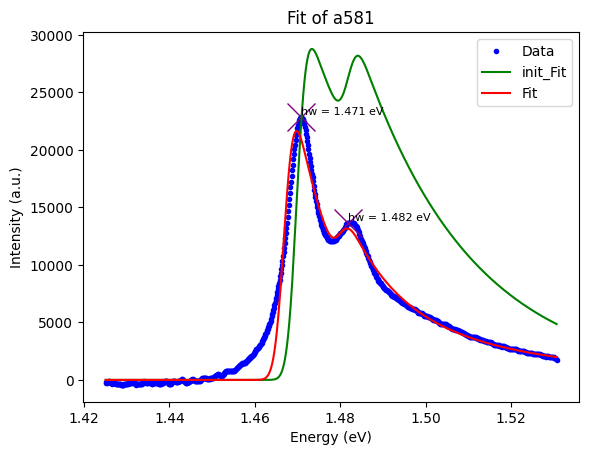

[1.4251057291172444, 1.5306691164592623]


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_srez["ln_I"] = np.log(data_srez["I"])


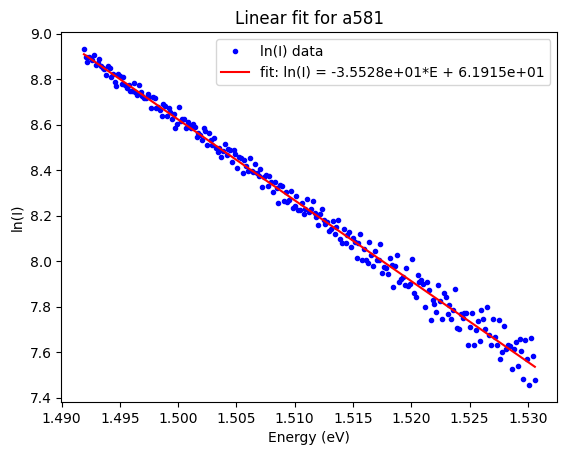

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)


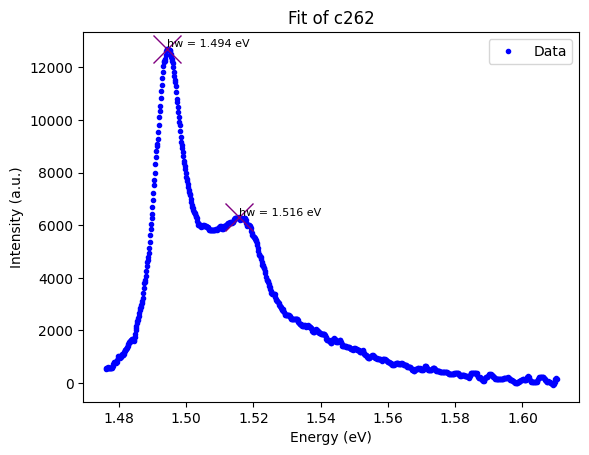

[1.4760023623000031, 1.610184395236367]


c:\Users\RedBrean\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_srez["ln_I"] = np.log(data_srez["I"])


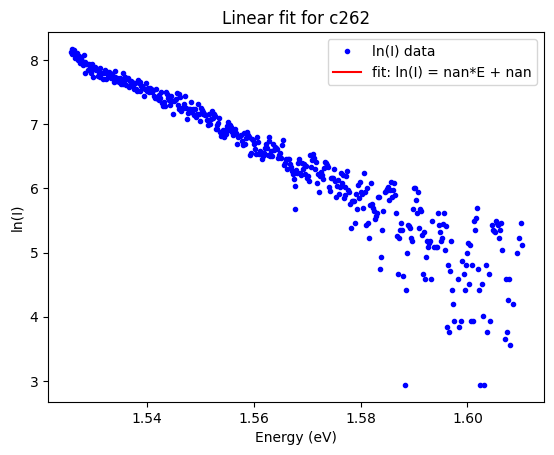

In [228]:

a581.filter_data()
a581.calc_sample(init_params=[1.47, 300, 200000, 1.482, 300, 100000], k_sigmoida=400, try_fit=True)
a581.calc_temperature_with_log()

c262.filter_data(window_length=6)
c262.calc_sample(init_params=[1.49, 300, 50000, 1.515, 300, 100000], k_sigmoida=400)
c262.calc_temperature_with_log()

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)


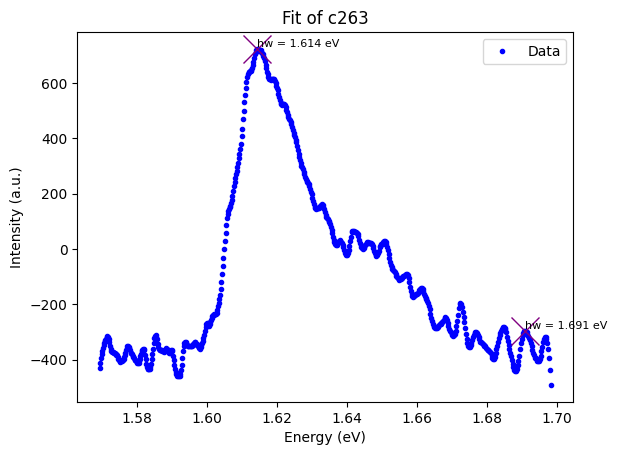

In [229]:

c263.filter_data(window_length=20)
c263.calc_sample(init_params=[1.62, 300, 500000, 1.63, 300, 1000], k_sigmoida=400)



C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"] = sp.signal.medfilt(self.data_filtered["I"], kernel_size=kernel_size)   # 3, 5 или 7
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_filtered["I"]= sp.signal.savgol_filter(self.data_filtered["I"], window_length=window_length, polyorder=polyorder, axis=0)


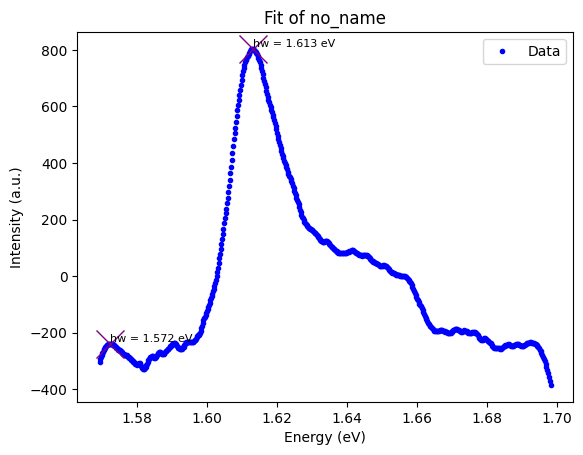

In [230]:

no_name.filter_data(window_length=60)
no_name.calc_sample(init_params=[1.52, 300, 50000000, 1.545, 300, 100000], k_sigmoida=400)

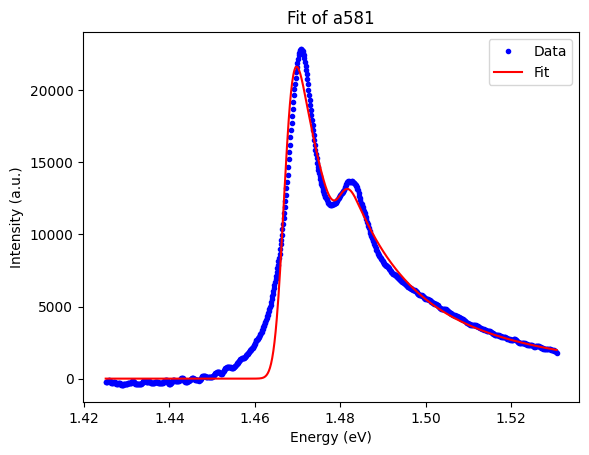

[1.4251057291172444, 1.5306691164592623]


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_14260\2175604864.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_srez["ln_I"] = np.log(data_srez["I"])


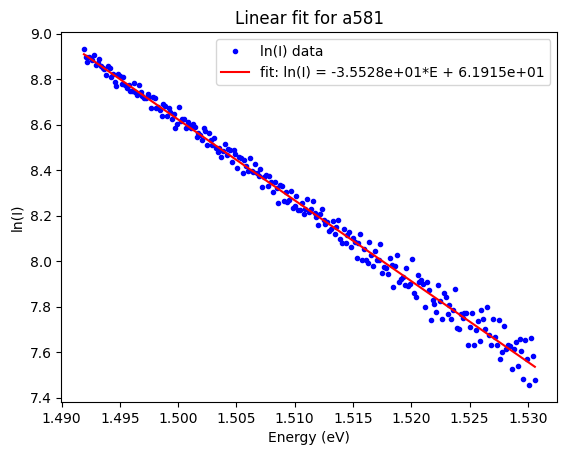

Sample a581: T_h = 326.62704347028426 K, T_hh = 0.00 K, T_lh = 0.00 K, DeltaE = 0.011 eV


In [231]:
a581.plot_samople()
a581.calc_temperature_with_log()
a581.print_data()